# Security Assignement 1
**Section 2** <br>
**Belal Hmeidat 1202295**<br>
**Othman Ali 1202927** <br>

**2024-05-07**

## Introduction
In this notebook, we will test a prominent face recognition library against a dataset of celebrity faces to calculate False Match Rate and False Non-Match Rate for a selected group of celebrities. face_recognition is a Python library that features a state of the art face recognition model. It is already trained and easy to test, only encode some pictures belonging to one person and compare their encodings against the encoding of another picture to see if they match. <br>
The thresholds we are using are [0.5, 0.55, 0.6, 0.65, 0.7] with the default threshold for the library is 0.6. <br>
Dataset used: https://www.kaggle.com/datasets/hereisburak/pins-face-recognition (Please put the folder called **105_classes_pins_dataset** in the same directory as this notebook)<br>
Relevant Research Reviewed:  [Real-Time Implementation Of Face Recognition System](https://ieeexplore.ieee.org/document/8282685)<br>
Resources: https://pypi.org/project/face-recognition/ <br>
git repo: https://github.com/BelalHmeidat/false-match-non-match


## Literature Review
In their article Real-Time Implementation Of Face Recognition System - 2017, Mr. Borkar and Dr. Kuwelkar talk about the face recognition process and different face recognition algorithms such as PCA and LDA. They also presented a mathematical example to face recognition performed on the Raspberry Pi 3 using the Emulsion Distance measure we will use in this experiment.

## Importing libs

In [2]:
import face_recognition #trained face recognetion model to decide if two images belong to the same person
import numpy as np # to calculate the distance between two images
import os #to read files
from PIL import Image #to display images
import random # to sample random image files from the dataset
import matplotlib.pyplot as plt #to plot charts
import pandas as pd # to create tables

## Preparing Templates
Choosing people and storing their biometric identifiers

Adriana Leema image:


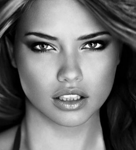

Jeff Bezos image:


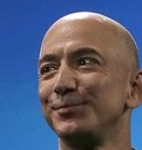

Emilia Clarke image:


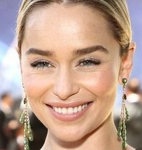

Chris Hemsworth image:


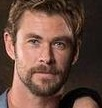

Margot Robbie image:


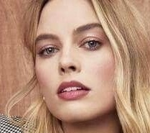

In [4]:
PEOPLE = ['Adriana Leema',
          'Jeff Bezos',
          'Emilia Clarke',
          'Chris Hemsworth',
          'Margot Robbie'
          ] # people we selected to compare

BASE_URL = './105_classes_pins_dataset/' #location of the dataset

PEOPLE_FOLDERS = { # folders that contains pics for each person
    'Adriana Leema' : 'pins_Adriana Lima',
    'Jeff Bezos' : 'pins_jeff bezos',
    'Emilia Clarke':'pins_Emilia Clarke',
    'Chris Hemsworth' : 'pins_Chris Hemsworth',
    'Margot Robbie' : 'pins_margot robbie'
}

PEOPLE_PICS = {}


for person in PEOPLE:
    print(f'{person} image:')
    folder_path = os.path.join(BASE_URL, PEOPLE_FOLDERS[person]) # getting the path for each person's folder
    file_names = os.listdir(folder_path) # listing the content of the folder
    image_files = [file for file in file_names if file.endswith(('jpg', 'png', 'jpeg'))] # getting pictures content 
    image_path = os.path.join(folder_path, random.sample(image_files, 1)[0]) # getting the path for a random image belonging to the person
    image = Image.open(image_path) #viewing the image
    image.thumbnail((150, 150))
    PEOPLE_PICS[person] = image_path
    display(image)


## Creating Encodings
Creating an encoding for each person using the images showed above. At first we tried merging multiple encodings of images belonging to the person by averaging the merged encoding matrices but this lead to worse accuracy so we reverted back using the encoding given by the library untouched.

In [5]:
encodings = {} # dictionary to store the encoding for each person

for person in PEOPLE:
  image_file = PEOPLE_PICS[person]
  image = face_recognition.load_image_file(image_file)
  encoding = face_recognition.face_encodings(image)[0]
  encodings[person] = encoding

## Testing
Comparing random images against the stored identity encodings of the people we picked and stored as templates.

### False Non Match Rate
Calculating the false non-match rate for each template. Instead of sampling random images and labeling each one to check if it belongs to the person in the template, we simply check the template against the pictures that we know belong to the person of the given template. Ideally the algorithm should identify all of the pictures to match the person in the template. If the algorithm decides that one of the pictures doesn't belong to that person this counts as a false non-match.

In [6]:
thresholds = [0.5, 0.55, 0.60, 0.65, 0.7]
def calc_non_match(thresholds):
  non_match_thresholds_error = {}
  # going over each template to compare its encoding to the encodings of other images belonging to the same person
  for person in PEOPLE:
    non_match_thresholds_error[person] = { # dict to hold the false non-match percentage for each person
      'thresholds' : [],
      'errors' : [],
      'distances' : []
    }
    person_folder = PEOPLE_FOLDERS[person] 
    person_folder_path = os.path.join(BASE_URL, person_folder) # template folder path to perform testing against its content
    file_names = os.listdir(person_folder_path)
    image_files_paths = [os.path.join(person_folder_path, file) for file in file_names if file.endswith(('jpg', 'png', 'jpeg'))] # selecting all image content
    testing_pool_size = len(image_files_paths)
    for threshold in thresholds: # testing the same images against the template but with different thresholds
      error_count = 0 # error count for each person
      for image_path in image_files_paths:
        image = face_recognition.load_image_file(image_path)
        image_encoding = face_recognition.face_encodings(image)
        if not image_encoding: #if list is empty (image wasn't identified to have a face - counts as false match)
          result[0] = False
          distance = 'N/A'
        else:
          result = face_recognition.compare_faces([encodings[person]], image_encoding[0], tolerance=threshold)
          distance = np.linalg.norm(encodings[person] - image_encoding[0])
          non_match_thresholds_error[person]['distances'].append(distance)
        if not result[0]:
          error_count+=1
          # print(f'Found false non-match for {person}, Euclidean distance = {distance}, threshold = {threshold}')
      error_percentage =  float(error_count) / testing_pool_size * 100
      print(f' --- False non-matches for {person}: {error_percentage}%, threshold = {threshold} ---')
      non_match_thresholds_error[person]['thresholds'].append(threshold) #adding threshold to the dict
      non_match_thresholds_error[person]['errors'].append(error_percentage) # adding corresponding error percentage to the dict
  return non_match_thresholds_error
non_match_thresholds_error = calc_non_match(thresholds)

 --- False non-matches for Adriana Leema: 57.27699530516433%, threshold = 0.5 ---
 --- False non-matches for Adriana Leema: 24.413145539906104%, threshold = 0.55 ---
 --- False non-matches for Adriana Leema: 4.225352112676056%, threshold = 0.6 ---
 --- False non-matches for Adriana Leema: 0.9389671361502347%, threshold = 0.65 ---
 --- False non-matches for Adriana Leema: 0.4694835680751174%, threshold = 0.7 ---
 --- False non-matches for Jeff Bezos: 29.245283018867923%, threshold = 0.5 ---
 --- False non-matches for Jeff Bezos: 6.60377358490566%, threshold = 0.55 ---
 --- False non-matches for Jeff Bezos: 2.8301886792452833%, threshold = 0.6 ---
 --- False non-matches for Jeff Bezos: 1.8867924528301887%, threshold = 0.65 ---
 --- False non-matches for Jeff Bezos: 0.9433962264150944%, threshold = 0.7 ---
 --- False non-matches for Emilia Clarke: 49.047619047619044%, threshold = 0.5 ---
 --- False non-matches for Emilia Clarke: 23.333333333333332%, threshold = 0.55 ---
 --- False non-mat

#### Results
Below are tables that show information about false non-match rate with different thresholds. As well as the distance results of the tests for each template.

##### False Non-Match Rate VS Threshold Table

In [28]:
data = {}
for person in PEOPLE:
    data[person] = non_match_thresholds_error[person]['errors']
df = pd.DataFrame(columns= non_match_thresholds_error.keys(), index=thresholds, data=data)
df


,Adriana Leema,Jeff Bezos,Emilia Clarke,Chris Hemsworth,Margot Robbie
0.50,57.276995,29.245283,49.047619,27.044025,58.371041
0.55,24.413146,6.603774,23.333333,10.062893,33.484163
0.60,4.225352,2.830189,10.952381,4.402516,10.407240
0.65,0.938967,1.886792,3.333333,2.515723,3.167421
0.70,0.469484,0.943396,2.380952,1.257862,0.904977


##### False Non-Match Test Distances

In [29]:
data = {}
for person in PEOPLE:
    data[person] = non_match_thresholds_error[person]['distances'][:50]
df = pd.DataFrame(columns= non_match_thresholds_error.keys(), data=data)
df

,Adriana Leema,Jeff Bezos,Emilia Clarke,Chris Hemsworth,Margot Robbie
0,0.461158,0.000000,0.467277,0.497694,0.569669
1,0.473104,0.477345,0.562573,0.461053,0.492911
2,0.461287,0.444291,0.591623,0.481695,0.554416
3,0.483533,0.531899,0.497084,0.565536,0.532754
4,0.504419,0.478018,0.558567,0.509538,0.549082
5,0.551858,0.464900,0.445513,0.409655,0.547970
6,0.540858,0.512000,0.412250,0.415496,0.425774
7,0.428981,0.459340,0.569334,0.409845,0.397202
8,0.516681,0.513949,0.000000,0.384691,0.573530
9,0.477044,0.415066,0.361939,0.485540,0.558111


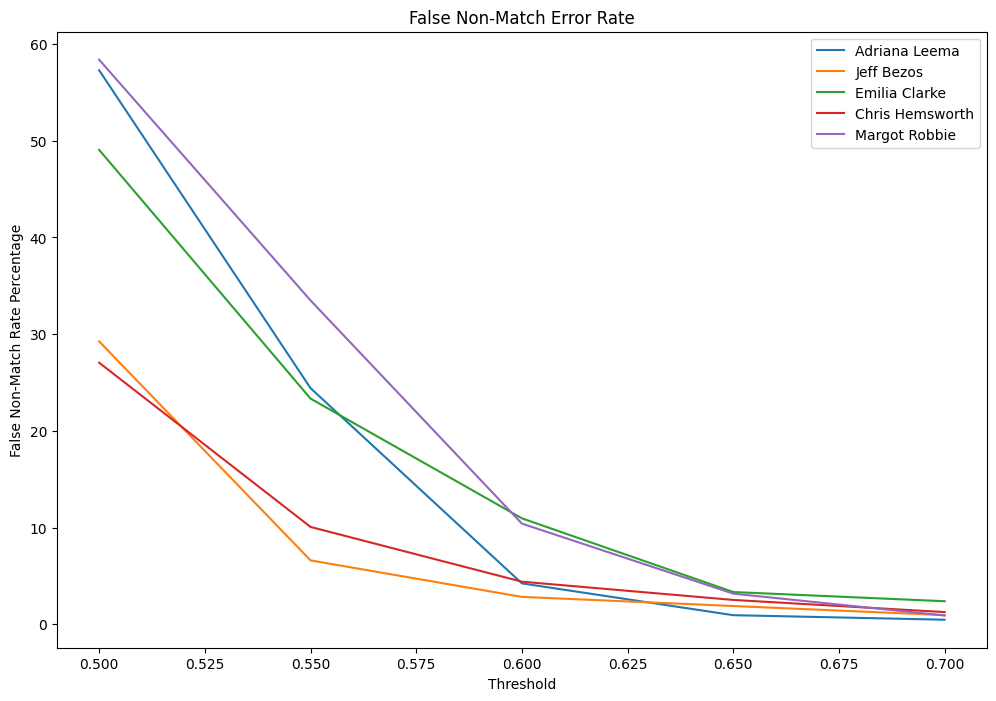

In [15]:
plt.figure(figsize=(12, 8)) 
for person in PEOPLE:
    plt.plot(non_match_thresholds_error[person]['thresholds'], non_match_thresholds_error[person]['errors'], label=person)
plt.xlabel('Threshold')
plt.ylabel('False Non-Match Rate Percentage')
plt.title('False Non-Match Error Rate')
plt.legend()
plt.show()

#### Graph Interpretation
The graph shows the false non-match rate decreasing across all 5 selected templates as the threshold increases. This due to the tolerance (threshold) increase causing the algorithm to allow a bigger margin of error when matching faces. The graph shows a dramatic change in the false non-match rate when going from a threshold value of 0.5 to 0.6 but not as much when going from 0.6 threshold to larger values as the plot line flattens from there onward.

### False Match Rate
To test the algorithm against false match rate, we decided to randomly select pictures from the whole picture dataset but excluding pictures that belong to the person of the template we are testing against. Ideally, the algorithm shouldn't match any of these pictures to the template but if it does, then this counts as a case of false match. Below is an image of a result from an early test showing example of false matching. ![alt text](<Screenshot 2024-05-08 at 12.10.39 AM.png>)

In [22]:
def calc_false_match(thresholds, test_size):
  false_match_thresholds_error = {}
  file_paths_pool = [] # pool that will include the paths of all the images in the dataset
  list_of_folders = os.listdir(BASE_URL) # listing all directories 
  # remove hidden files
  list_of_folders = [folder for folder in list_of_folders if not folder.startswith('.')]
  list_of_folder_paths = [os.path.join(BASE_URL, folder) for folder in list_of_folders] # listing the relative path of all directories
  for folder_path in list_of_folder_paths: 
    file_names = os.listdir(folder_path) # listing all files in the directory
    image_files_paths = [os.path.join(folder_path, file) for file in file_names if file.endswith(('jpg', 'png', 'jpeg'))] # selecting all image content and adding their paths
    file_paths_pool.extend(image_files_paths) # adding the image paths to the pool
  # going over each template to compare its encoding to the encodings of randomly selected images of other people
  for person in PEOPLE:   
    print('-----------------------------------')
    print('Calculating false matches for', person)
    false_match_thresholds_error[person] = {
      'thresholds' : [],
      'errors' : [],
      'distances' : []
    }
    person_folder = PEOPLE_FOLDERS[person] #folder files to be excluded
    person_folder_path = os.path.join(BASE_URL, person_folder) # relative path of the folder to be excluded
    pool_without_person_files = [file_path for file_path in file_paths_pool if person_folder_path not in file_path ] # excluding the files of the person from the pool
    random_file_paths = random.sample(pool_without_person_files, test_size) # selecting random images from the pool
    testing_pool_size = len(random_file_paths)
    for threshold in thresholds:
      error_count = 0
      for image_path in random_file_paths:
        image = face_recognition.load_image_file(image_path) 
        image_encoding = face_recognition.face_encodings(image)
        if not image_encoding: #if list is empty (image wasn't identified to have a face - skips it)
          if threshold == thresholds[0]:
            testing_pool_size-=1
          continue
        else:
          result = face_recognition.compare_faces([encodings[person]], image_encoding[0], tolerance=threshold) # returns a list of single boolean
          distance = np.linalg.norm(encodings[person] - image_encoding[0])
          if threshold == thresholds[0]:
            false_match_thresholds_error[person]['distances'].append(distance)
        if result[0]: 
          error_count+=1
          # ** -- uncomment to display false match images information -- **
          # print(f'Found false match for {person}, Euclidean distance = {distance}, threshold = {threshold}')
          # print(f'"{image_path}"')
          # image = Image.open(image_path)
          # image.thumbnail((100, 100))
          # display(image)
      error_percentage =  float(error_count) / testing_pool_size * 100 # calculating false match percentage
      print(f' --- False matches for {person}: {error_percentage}%, threshold = {threshold}. ---')
      false_match_thresholds_error[person]['thresholds'].append(threshold)
      false_match_thresholds_error[person]['errors'].append(error_percentage)
  return false_match_thresholds_error

false_match_thresholds_error = calc_false_match(thresholds, 1000) # testing 100 random images from the dataset

-----------------------------------
Calculating false matches for Adriana Leema
 --- False matches for Adriana Leema: 0.0%, threshold = 0.5. ---
 --- False matches for Adriana Leema: 0.0%, threshold = 0.55. ---
 --- False matches for Adriana Leema: 0.6128702757916241%, threshold = 0.6. ---
 --- False matches for Adriana Leema: 5.209397344228805%, threshold = 0.65. ---
 --- False matches for Adriana Leema: 13.381001021450459%, threshold = 0.7. ---
-----------------------------------
Calculating false matches for Jeff Bezos
 --- False matches for Jeff Bezos: 0.0%, threshold = 0.5. ---
 --- False matches for Jeff Bezos: 0.0%, threshold = 0.55. ---
 --- False matches for Jeff Bezos: 0.2044989775051125%, threshold = 0.6. ---
 --- False matches for Jeff Bezos: 0.6134969325153374%, threshold = 0.65. ---
 --- False matches for Jeff Bezos: 3.374233128834356%, threshold = 0.7. ---
-----------------------------------
Calculating false matches for Emilia Clarke
 --- False matches for Emilia Clarke

#### Results
Below are tables that show information about the false match rate and rate with different thresholds. As well as the distance results of the tests for each template.

##### False Match Rate VS Threshold Table

In [30]:
data = {}
for person in PEOPLE:
    data[person] = false_match_thresholds_error[person]['errors']
df = pd.DataFrame(columns= false_match_thresholds_error.keys(), index=thresholds, data=data)
df

,Adriana Leema,Jeff Bezos,Emilia Clarke,Chris Hemsworth,Margot Robbie
0.50,0.000000,0.000000,0.000000,0.101317,0.000000
0.55,0.000000,0.000000,0.000000,0.202634,0.204918
0.60,0.612870,0.204499,0.610998,0.810537,0.614754
0.65,5.209397,0.613497,3.258656,2.228977,2.971311
0.70,13.381001,3.374233,8.248473,6.889564,9.938525


##### False Match Distances for Threshold 0.5

In [31]:
data = {}
for person in PEOPLE:
    data[person] = false_match_thresholds_error[person]['distances'][:50] # displaying the first 50 distances
df = pd.DataFrame(columns= false_match_thresholds_error.keys(), data=data)
df

,Adriana Leema,Jeff Bezos,Emilia Clarke,Chris Hemsworth,Margot Robbie
0,0.990142,0.921553,0.957622,0.796706,0.971616
1,0.650338,0.725692,1.067796,0.669462,1.011690
2,0.774027,0.774045,0.973256,0.869048,0.665713
3,1.042288,0.697639,0.833927,0.974461,0.932841
4,0.942877,0.857331,0.943827,0.758138,0.810034
5,0.973775,0.867441,0.713141,0.839898,0.979522
6,0.958006,0.892991,0.999606,0.938298,0.881165
7,1.027356,0.799665,0.906056,0.755518,0.772242
8,0.950432,0.893304,0.859068,0.752209,0.960432
9,0.791972,0.886681,1.000090,0.824850,1.035796


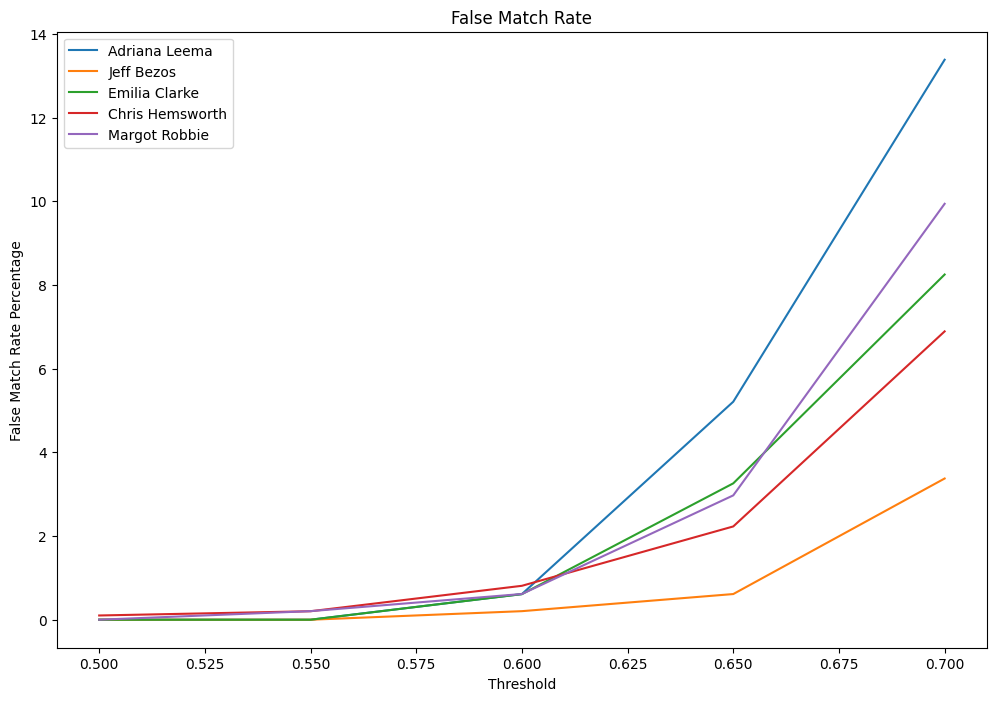

In [25]:
plt.figure(figsize=(12, 8)) 
for person in PEOPLE:
    plt.plot(false_match_thresholds_error[person]['thresholds'], false_match_thresholds_error[person]['errors'], label=person)
plt.xlabel('Threshold')
plt.ylabel('False Match Rate Percentage')
plt.title('False Match Rate')
plt.legend()
plt.show()

#### Graph Interpretation
The graph shows consistent increase in false match rate across all templates when the threshold value is increased. The algorithm rarely mistakes someone else for the identity of the people stored in the templates at tolerance values 0.55 and lower. On the other hand, the false match rate dramatically shoots up to 8-10% at 0.7 tolerance values.

### Receiver Operating Characteristic
Below we graphed FMR vs FMNR for the same thresholds for each of the templates we selected

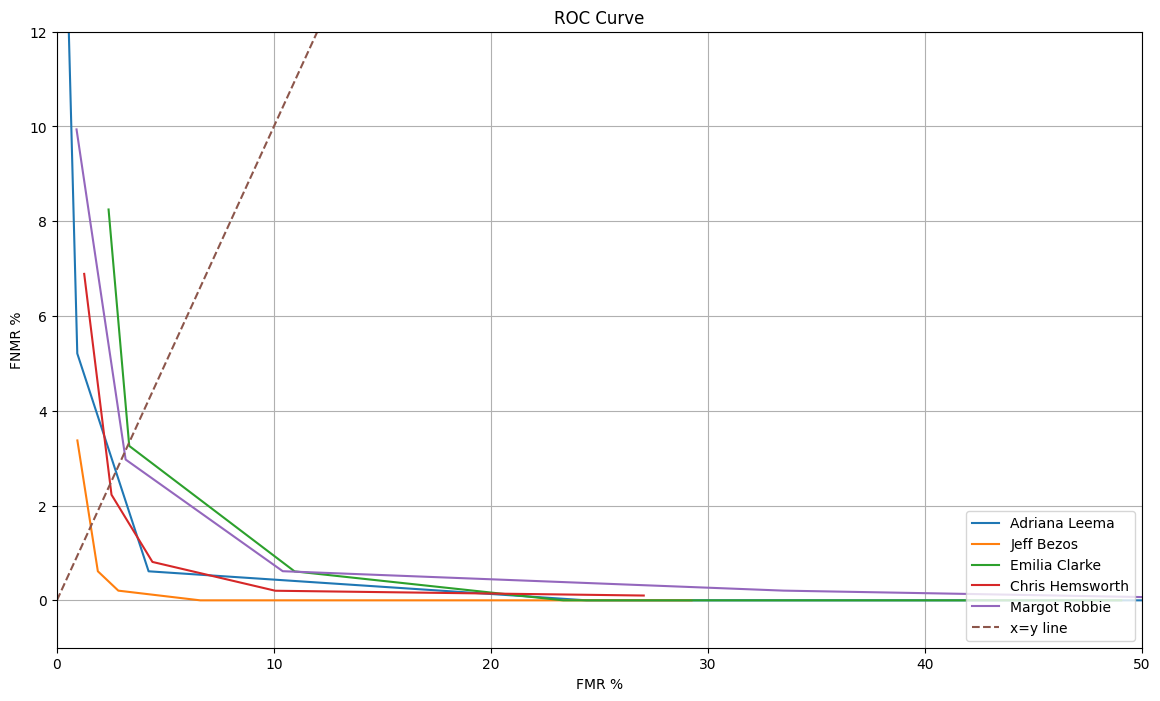

In [32]:
plt.figure(figsize=(14, 8))
for person in PEOPLE:
    false_positive_rate = non_match_thresholds_error[person]['errors']
    true_positive_rate = false_match_thresholds_error[person]['errors']
    plt.plot(false_positive_rate, true_positive_rate, label=person) 
plt.plot(np.linspace(0, 90, 100), np.linspace(0,90, 100), label='x=y line', linestyle='--') # x = y line
plt.xlim(0, 50)
plt.ylim(-1, 12)
plt.xlabel('FMR %')
plt.ylabel('FNMR %')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#### Graph Interpretation
The graph shows the plots mainly found in the left bottom corner of the cartesian plain with near symmetry around the x = y asymptote. This is correct since FMR and FNMR respond differently to the increase of tolerance. FMR decreases as tolerance (threshold) increases whereas FNMR increases. The graph also shows the Equal Error Rate for each template on the intersection points with the x = y plot.

## Discussion
The library clearly demonstrated its ability to recognize faces against different values of tolerances and in numerous tests across all templates. It correctly showed the change of FMR and FNMR in response to the change in tolerance in accordance with theory. The face recognition accuracy can be improved by including multiple encodings for the templates in the comparison rather than comparing against one encoding. It can also be improved by filtering the image pool and keeping only good (passport) photos. As for the runtime performance nothing much can be done about it other than using smaller images but the images used are already small.

## References 
N. R. Borkar and S. Kuwelkar, "Real-time implementation of face recognition system," 2017 International Conference on Computing Methodologies and Communication (ICCMC), Erode, India, 2017, pp. 249-255, doi: 10.1109/ICCMC.2017.8282685. keywords: {Face recognition;Principal component analysis;Face;Algorithm design and analysis;Jacobian matrices;Training;Databases;Principle Componet Analysys;Linear Descriminant Analysys;EigenVectors;EigenValues;Raspberry Pi;Python},
